In [ ]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO
import itertools
import random
import tqdm

## K-means Algorithm

In [ ]:
Vector = np.ndarray

# Quantidade de atributos diferentes (distância de Hamming)
def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0

def squared_distance(v: Vector, w: Vector) -> float:
    """Computa (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    diff = v - w
    return np.dot(diff, diff)

def vector_mean(vectors: List[Vector]) -> Vector:
    return np.mean(np.array(vectors), axis=0)

In [ ]:
# Calcula as médias de um grupo
def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contém os inputs cuja atribuição é i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # se um cluster estiver vazio, usa apenas um ponto aleatório
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

In [ ]:
class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # número de clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """retorna o índice do cluster mais próximo do input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Inicia com atribuições aleatórias
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Computa as médias e encontra novas atribuições
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Verifica quantas atribuições mudaram e se terminamos
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Caso contrário, mantém as novas atribuições e computa novas médias
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"mudou: {num_changed} / {len(inputs)}")

## Agrupando Cores

In [ ]:
def download_image(url):
    # Baixar a imagem da URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Converter imagem em array de pixels
def image_to_pixels(img):
    img_array = np.array(img) / 256  # Normalizar os valores dos pixels entre 0 e 1
    return img_array.reshape(-1, 3)  # Achatar para lista de pixels RGB

# Reconstruir imagem a partir dos pixels recoloridos
def pixels_to_image(pixels, shape):
    new_img_array = pixels.reshape(shape)
    return new_img_array

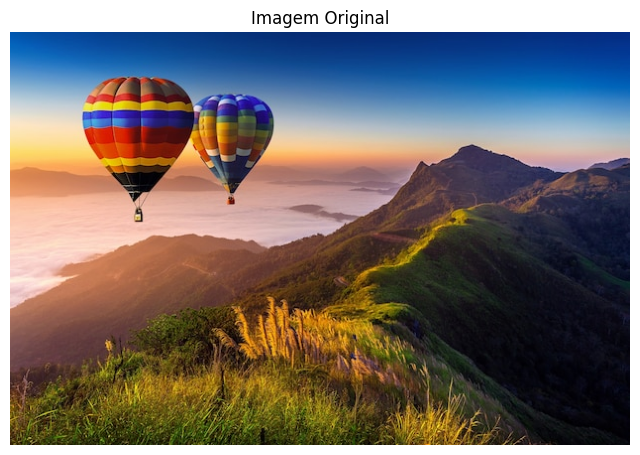

In [ ]:
# URL da imagem
image_url = "https://img.freepik.com/fotos-gratis/paisagem-de-nevoeiro-matinal-e-montanhas-com-baloes-de-ar-quente-ao-nascer-do-sol_335224-794.jpg?semt=ais_hybrid"

# Baixar e carregar a imagem
img = download_image(image_url)

# Exibir a imagem original
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Imagem Original")
plt.show()
print("\n\n")

mudou: 2 / 261042: : 31it [03:21,  6.51s/it]


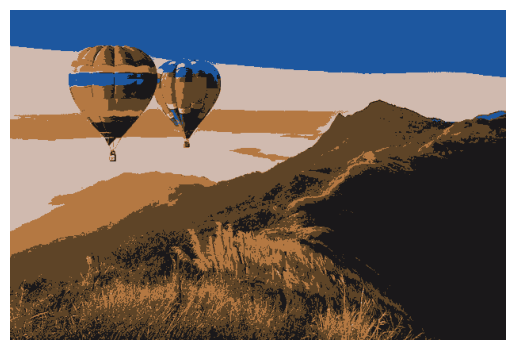

In [ ]:
# Converter para lista de pixels
img_shape = np.array(img).shape  # Guardar o formato original para a reconstrução
pixels = image_to_pixels(img)

# Treinar o modelo de K-Means
k = 5  # Número de clusters desejado
clusterer = KMeans(k)
clusterer.train(pixels.tolist())  # Convertendo para lista para o método 'train'

# Recolorir a imagem
recolored_pixels = [clusterer.means[clusterer.classify(pixel)] for pixel in pixels]
recolored_pixels = np.array(recolored_pixels)  # Convertendo de volta para numpy array
new_img_array = pixels_to_image(recolored_pixels, img_shape)  # Restaurar formato original

# Exibir a imagem recolorida
plt.imshow(new_img_array)
plt.axis('off')
plt.title("Imagem Alterada")
plt.show()